In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import bernoulli
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.svm import SVC

In [2]:
mushrooms_whole = pd.read_csv('mushroom.csv')
classes = mushrooms_whole['class'].copy()
colnames = mushrooms_whole.drop(['class'], axis=1).columns
mushrooms_whole = StandardScaler().fit_transform(X=mushrooms_whole.drop(['class'],axis=1).to_numpy())
mushrooms_whole = pd.DataFrame(mushrooms_whole)
mushrooms_whole.columns = colnames
mushrooms_whole['class'] = classes
mushrooms = mushrooms_whole.sample(frac=0.1)
indexes_to_drop_imp = list(mushrooms.index)
mushroom_test = mushrooms_whole.drop(labels=indexes_to_drop_imp)
mushrooms = mushrooms.reset_index(drop=True)
mushroom_test = mushroom_test.reset_index(drop=True)
#mushrooms
#mushroom_test

In [3]:
def rbf(x,y,l=1):
    """Gaussian kernel

    Parameters
    -------------------------------
    x : float
    a real number

    y : float
    a real number

    l: float, non zero
    a scale parameter
    -------------------------------
    """
    dim = x.shape[0]
    vect = np.empty(dim)
    if dim == y.shape[0]  :
        d = np.exp(-((np.linalg.norm(x-y))**2)/(2*(l**2)))
        return d
    else :
        for i in range(dim):
            vect[i] = np.exp(-((np.linalg.norm(x[i] - y))**2)/(2*(l**2)))
        return vect

In [4]:
#First, the cluster step, to 'initialize' the labels, and the creation of unlabeled data
n_samples = mushrooms.shape[0]
mushrooms['label'] = np.ones(n_samples)*(-1)

for i in mushrooms.index:
    random = bernoulli.rvs(p=3/4)
    if mushrooms.loc[i,'class'] == 1 and random == 0:
        mushrooms.loc[i,'label'] = 1
    else:
        mushrooms.loc[i,'label'] = -1

n_cluster = 5
clusterized_data = KMeans(n_clusters=n_cluster, init='random').fit(mushrooms.drop(['class','label'],axis=1))
mushrooms['cluster'] = clusterized_data.labels_

list_of_ratio = []
for i in range(n_cluster):
    list_of_ratio.append(mushrooms[mushrooms['cluster'] == i]['label'].sum()/mushrooms[mushrooms['cluster'] == i]['class'].shape[0])
list_of_ratio = np.array(list_of_ratio)
positive_cluster = np.argmax(list_of_ratio)
negative_cluster = np.argmin(list_of_ratio)
print('the cluster containing positive values is : ', positive_cluster, '\n', 
      'the one containing negative exampels is : ', negative_cluster)

reliable_positives = mushrooms[mushrooms['cluster'] == positive_cluster]
reliable_positives = reliable_positives[reliable_positives['label'] == 1]
reliable_negatives = mushrooms[mushrooms['cluster'] == negative_cluster]
reliable_negatives = reliable_negatives[reliable_negatives['label'] == -1]
reliable_negatives = reliable_negatives.sample(n=reliable_positives.shape[0]) #to adjust the class balance ratio

the cluster containing positive values is :  0 
 the one containing negative exampels is :  1


In [5]:
#first svm part
gamma = 1
positives_array = reliable_positives.drop(['class','cluster'], axis=1)
negatives_array = reliable_negatives.drop(['class', 'cluster'], axis=1)
data_svm = np.vstack((positives_array,negatives_array))
n_reliable = data_svm.shape[0]
outcome = data_svm[:,8]
data_svm = data_svm[:,:8]
omega = np.zeros((n_reliable,n_reliable))
for k in range(n_reliable):
    for i in range(k,n_reliable):
        omega[k,i] = outcome[k]*outcome[i]*rbf(x=data_svm[k,:],y=data_svm[i,:],l=10)
omega_t = np.transpose(omega)
omega = omega_t + omega
for i in range(n_reliable):
    omega[i,i] = 1


#now, computation of the rest of the matrix
first_row = np.hstack((0,-np.transpose(outcome)))
first_row = first_row.reshape(1,first_row.shape[0])
bot_of_mat_right = omega + (1/gamma)*np.eye(n_reliable)
bot_of_mat = np.hstack((outcome.reshape(n_reliable,1), bot_of_mat_right))
whole_mat = np.vstack((first_row, bot_of_mat))
right_hand = np.ones(n_reliable+1)
right_hand[0] = 0

#we get the coefficients
coeffs = np.linalg.solve(a=whole_mat,b=right_hand)
b = coeffs[0]
alpha = coeffs[1:coeffs.shape[0]]

#now we compute the wt \phi(x) and then we order them 
test_data = mushrooms.drop(['class','label','cluster'], axis=1).to_numpy()
results = np.empty(n_samples)
for i in tqdm(range(n_samples)):
    results[i] = np.sum(alpha*outcome*rbf(x=data_svm,y=test_data[i,:],l=10))
sorted_results = np.sort(results)
good_ratio = int(n_samples/2)
b = sorted_results[good_ratio]

last_results = np.empty(n_samples)
for i in range(n_samples):
    last_results[i] = np.sign(results[i] - b)

mushrooms['it_results'] = last_results
correct_with_b = 0
for i in range(reliable_positives.shape[0]):
    if mushrooms.loc[reliable_positives.index[i],'it_results'] == 1:
        correct_with_b += 1
missclass = reliable_positives.shape[0] - correct_with_b

100%|██████████| 5404/5404 [00:22<00:00, 238.07it/s]


In [6]:
b

-0.07594471234942546

In [7]:
compt_pos = 0
for i in range(len(last_results)):
    if last_results[i] == 1:
        compt_pos += 1

print('pos = ', compt_pos, ' and negatives = ', len(last_results) - compt_pos)

pos =  2701  and negatives =  2703


In [8]:
compteur = 0
max_iter = 500
while missclass!=0 and compteur<max_iter:
    compteur += 1
    if np.sign(b) == 1:
        b = (1+0.005)*b
    else:
        b = (1-0.005)*b
    last_results = np.zeros(n_samples)
    for i in range(n_samples):
        last_results[i] = np.sign(results[i] - b)

    mushrooms['it_results'] = last_results
    correct_with_b = 0
    for i in range(reliable_positives.shape[0]):
        if mushrooms.loc[reliable_positives.index[i],'it_results'] == 1:
            correct_with_b += 1
    missclass = reliable_positives.shape[0] - correct_with_b

In [9]:
b

-0.006194951552889135

In [10]:
mushrooms_it = mushrooms.copy()

In [11]:
good_ratio = int(n_samples/2)

In [12]:
for i in range(n_samples):
    if mushrooms_it.loc[mushrooms.index[i],'it_results'] == 0:
        mushrooms_it.loc[mushrooms.index[i],'it_results'] = -1
positives_new = mushrooms_it[mushrooms_it['it_results'] == 1]
positives_new = positives_new[positives_new['label'] == 1]
negatives_new = mushrooms_it[mushrooms_it['it_results'] == -1]
negatives_new = negatives_new[negatives_new['label'] == -1]
negatives_new = negatives_new.sample(n=positives_new.shape[0])

In [13]:
gamma = 1
positives_array_new = positives_new.drop(['class','cluster','label'], axis=1)
negatives_array_new = negatives_new.drop(['class', 'cluster','label'], axis=1)
data_svm_it = np.vstack((positives_array_new,negatives_array_new))
n_reliable = data_svm_it.shape[0]
outcome_it = data_svm_it[:,8].copy()
data_svm_it = data_svm_it[:,:8].copy()

In [14]:
omega_it = np.zeros((n_reliable,n_reliable))
for k in range(n_reliable):
    for i in range(k,n_reliable):
        omega_it[k,i] = outcome_it[k]*outcome_it[i]*rbf(x=data_svm_it[k,:],y=data_svm_it[i,:],l=10)
omega_it_t = np.transpose(omega_it)
omega_it = omega_it+omega_it_t
for i in range(n_reliable):
    omega_it[i,i] = 1

In [15]:
first_row_it = np.hstack((0,-np.transpose(outcome_it)))
first_row_it = first_row_it.reshape(1,first_row_it.shape[0])
bot_of_mat_right_it = omega_it + (1/gamma)*np.eye(n_reliable)
bot_of_mat_it = np.hstack((outcome_it.reshape(n_reliable,1), bot_of_mat_right_it))
whole_mat_it = np.vstack((first_row_it, bot_of_mat_it))
right_hand_it = np.ones(n_reliable+1)
right_hand_it[0] = 0
coeffs_it = np.linalg.solve(a=whole_mat_it,b=right_hand_it)
b_it = coeffs_it[0]
alpha_it = coeffs_it[1:coeffs_it.shape[0]]
test_data_it = mushrooms_it.drop(['class','label','cluster','it_results'], axis=1).to_numpy()
results_new = np.zeros(n_samples)

In [16]:
for i in range(n_samples):
    results_new[i] = np.sum(alpha_it*outcome_it*rbf(x=data_svm_it,y=test_data_it[i,:],l=10))
sorted_results_it = np.sort(results_new)
b_it = sorted_results_it[good_ratio]
last_results_it = np.zeros(n_samples)

In [17]:
b_it

-0.6413173859808126

In [18]:
for i in range(n_samples):
    last_results_it[i] = np.sign(results_new[i] - b_it)

In [19]:
compt_pos_bis = 0
for i in range(len(last_results_it)):
    if last_results_it[i] == 1:
        compt_pos_bis += 1

print('pos =', compt_pos_bis, 'negatives =', len(last_results_it) - compt_pos_bis)

pos = 2701 negatives = 2703


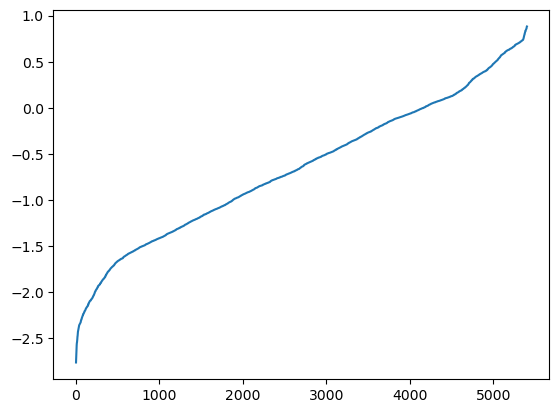

In [20]:
plt.plot(sorted_results_it)